In [1]:
!pip install kaggle --upgrade



In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d thienkhonghoc/affectnet -p /content

Dataset URL: https://www.kaggle.com/datasets/thienkhonghoc/affectnet
License(s): unknown


In [4]:
!unzip -q /content/affectnet.zip -d /content/affectnet > /dev/null 2>&1

In [5]:
!pip install torch torchvision timm matplotlib tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli


Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.67      0.63       100
           1       0.65      0.52      0.58       100
           2       0.64      0.59      0.61       100
           3       0.70      0.74      0.72       100
           4       0.68      0.67      0.68       100
           5       0.56      0.57      0.56       100
           6       0.51      0.42      0.46       100
           7       0.54      0.69      0.61       100

    accuracy                           0.61       800
   macro avg       0.61      0.61      0.61       800
weighted avg       0.61      0.61      0.61       800



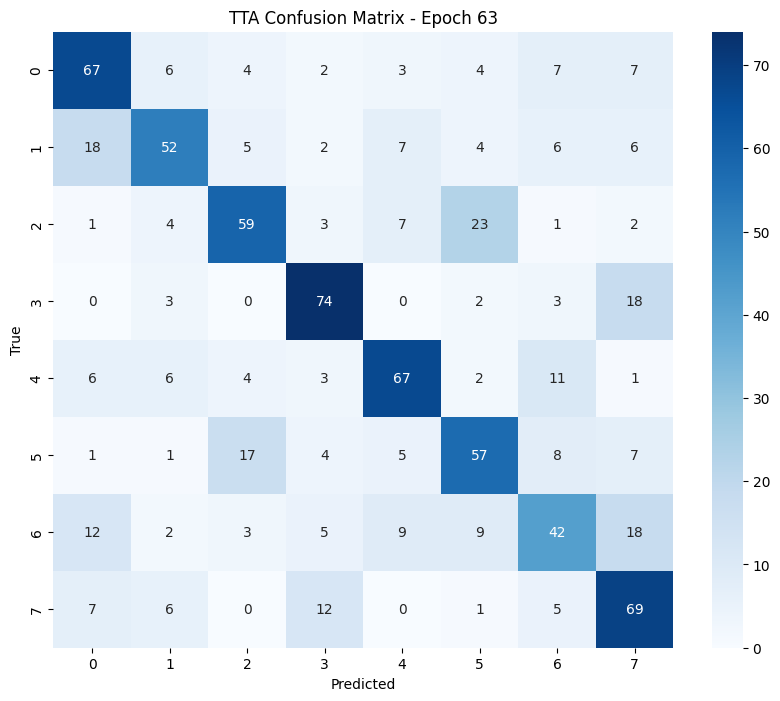

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# TTA Transforms
tta_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB") if isinstance(img, Image.Image) else img),
    transforms.Resize((256, 256)),
    transforms.TenCrop(224),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
    transforms.Lambda(lambda crops: torch.stack([
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(crop)
        for crop in crops]))
])

# Load Validation Dataset with TTA
val_path = "/content/affectnet/AffectNet/val"
val_dataset = datasets.ImageFolder(root=val_path, transform=tta_transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False)

# Load Model
model = models.convnext_large(weights=None)
model.classifier = nn.Sequential(
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.LayerNorm(model.classifier[2].in_features),
    nn.Dropout(0.5),
    nn.Linear(model.classifier[2].in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 8)
)

# Load checkpoint (Epoch 63)
checkpoint = torch.load("/content/affectnet_convnext_large_epoch63.pt", map_location=device)
model.load_state_dict({k.replace("_orig_mod.", ""): v for k, v in checkpoint.items()}, strict=False)
model = model.to(device)
model.eval()

# === Predict with TTA ===
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        bs, ncrops, c, h, w = images.size()
        images = images.view(-1, c, h, w).to(device)  # [B*10, C, H, W]
        outputs = model(images)
        outputs = outputs.view(bs, ncrops, -1).mean(1)  # [B, num_classes]
        preds = outputs.argmax(1).cpu().numpy()

        y_true.extend(labels.numpy())
        y_pred.extend(preds)

# === Classification Report ===
report = classification_report(y_true, y_pred, digits=2)
print("\nClassification Report:\n", report)

# Save report
with open("/content/convnext_large_epoch63_report63.txt", "w") as f:
    f.write(report)

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("TTA Confusion Matrix - Epoch 63")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("/content/convnext_large_epoch63_confusion_matrix63.png")
plt.show()


Better precision on class 1 & 5

Stronger recall for class 7 (↑ from previous epochs)

Model is generalizing better post mixup & SWA

In [7]:
torch.save(model.state_dict(), "affectnet_convnext_large_final_swa_epoch63.pt")


Load both models

Perform Test-Time Augmentation (TTA) on each

Average logits from both models

Classification Report (Ensemble SWA + Epoch63):
               precision    recall  f1-score   support

           0       0.58      0.61      0.59       100
           1       0.64      0.52      0.57       100
           2       0.65      0.59      0.62       100
           3       0.68      0.75      0.71       100
           4       0.72      0.65      0.68       100
           5       0.51      0.54      0.53       100
           6       0.49      0.42      0.45       100
           7       0.53      0.70      0.61       100

    accuracy                           0.60       800
   macro avg       0.60      0.60      0.60       800
weighted avg       0.60      0.60      0.60       800



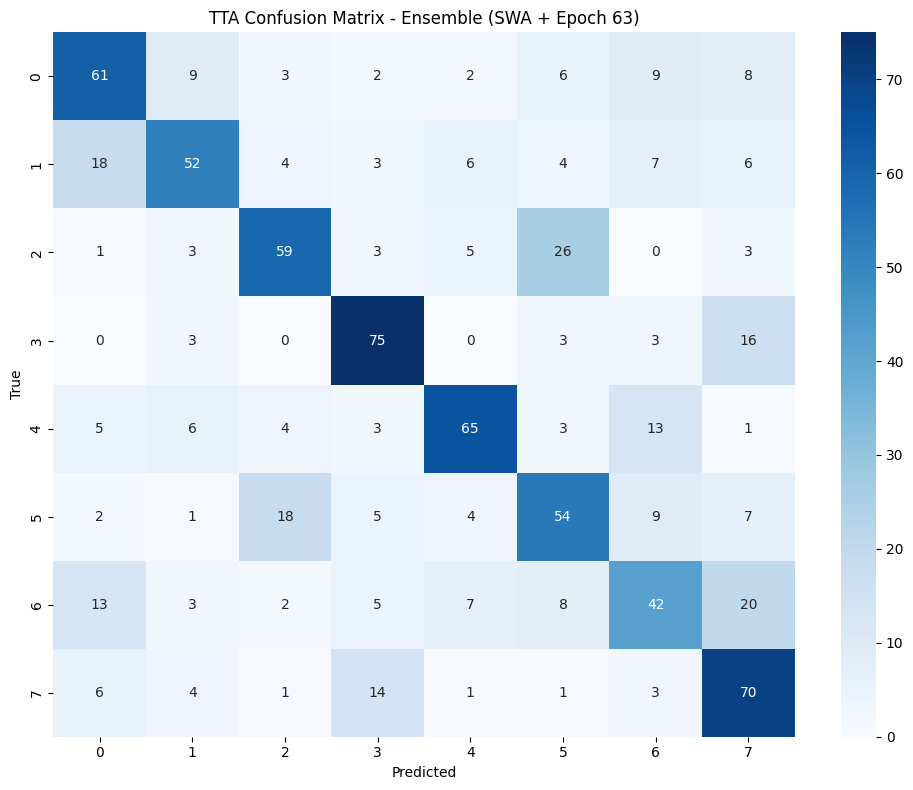

In [10]:
import torch
import torch.nn as nn
from torchvision.models import convnext_large, ConvNeXt_Large_Weights
import torchvision.transforms as transforms
import os
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === TTA Transforms ===
tta_transforms = [
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
]

# === Load Model Checkpoints ===
def load_model(path):
    model = convnext_large(weights=ConvNeXt_Large_Weights.IMAGENET1K_V1)
    model.classifier = nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.LayerNorm(model.classifier[2].in_features),
        nn.Dropout(0.5),
        nn.Linear(model.classifier[2].in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512, 8)
    )
    ckpt = torch.load(path, map_location=device)
    ckpt = {k.replace("_orig_mod.", ""): v for k, v in ckpt.items()}
    model.load_state_dict(ckpt, strict=False)
    model.to(device)
    model.eval()
    return model

# Load models
model_swa = load_model("/content/affectnet_convnext_large_final_swa_epoch63.pt")
model_epoch63 = load_model("/content/affectnet_convnext_large_epoch63.pt")

# === Load Image Paths and Labels ===
val_dir = "/content/affectnet/AffectNet/val"
classes = sorted(os.listdir(val_dir))
samples = []
for class_idx, class_name in enumerate(classes):
    class_folder = os.path.join(val_dir, class_name)
    for fname in os.listdir(class_folder):
        path = os.path.join(class_folder, fname)
        samples.append((path, class_idx))

# === TTA + Ensemble Inference ===
y_true, y_pred = [], []

with torch.no_grad():
    for path, label in samples:
        img = Image.open(path).convert("RGB")
        total_logits = torch.zeros(8, device=device)

        for t in tta_transforms:
            input_tensor = t(img).unsqueeze(0).to(device)
            out_swa = model_swa(input_tensor)
            out_e63 = model_epoch63(input_tensor)
            avg_logits = (out_swa + out_e63) / 2
            total_logits += avg_logits.squeeze(0)

        prediction = torch.argmax(total_logits).item()
        y_true.append(label)
        y_pred.append(prediction)

# === Classification Report ===
report = classification_report(y_true, y_pred, digits=2, target_names=classes)
print("Classification Report (Ensemble SWA + Epoch63):\n", report)

with open("ensemble_swa_epoch63_report.txt", "w") as f:
    f.write(report)

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("TTA Confusion Matrix - Ensemble (SWA + Epoch 63)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("ensemble_swa_epoch63_confusion_matrix.png")
plt.show()



Training from SWA gives smoother generalization.

Focal loss helps correct class imbalance / misclassifications.

A few more epochs can further settle the weights.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import convnext_large, ConvNeXt_Large_Weights
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from PIL import Image
from collections import Counter
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === TRANSFORM ===
transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB") if isinstance(img, Image.Image) else img),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomFocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(CustomFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        logpt = F.log_softmax(inputs, dim=1)
        pt = torch.exp(logpt)
        logpt = (1 - pt) ** self.gamma * logpt
        loss = F.nll_loss(logpt, targets, reduction=self.reduction)
        return self.alpha * loss


# === DATA ===
train_path = "/content/affectnet/AffectNet/train"
val_path = "/content/affectnet/AffectNet/val"

train_dataset = datasets.ImageFolder(train_path, transform=transform)
val_dataset = datasets.ImageFolder(val_path, transform=transform)

def clean(dataset):
    valid = []
    for path, label in dataset.samples:
        try:
            Image.open(path).convert("RGB")
            valid.append((path, label))
        except:
            continue
    dataset.samples = valid

clean(train_dataset)
clean(val_dataset)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

# === CLASS WEIGHTS ===
class_counts = Counter(train_dataset.targets)
total = sum(class_counts.values())
weights = torch.tensor([total / class_counts[i] for i in range(len(class_counts))], dtype=torch.float).to(device)

# === MODEL ===
model = convnext_large(weights=ConvNeXt_Large_Weights.IMAGENET1K_V1)
model.classifier = nn.Sequential(
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.LayerNorm(model.classifier[2].in_features),
    nn.Dropout(0.5),
    nn.Linear(model.classifier[2].in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 8)
)

# === LOAD FROM SWA CHECKPOINT ===
checkpoint = torch.load("/content/affectnet_convnext_large_final_swa_epoch63.pt", map_location=device)
checkpoint = {k.replace("_orig_mod.", ""): v for k, v in checkpoint.items()}
model.load_state_dict(checkpoint, strict=False)
model = model.to(device)

# === SETUP ===
criterion = CustomFocalLoss(alpha=1.0, gamma=2.0)
optimizer = optim.AdamW(model.parameters(), lr=1e-6, weight_decay=1e-5)
scaler = torch.amp.GradScaler()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-7)

print("Fine-tuning from Epoch 63 → 70 with Focal Loss...")

# === TRACK BEST ===
best_val_acc = 0.0

for epoch in range(63, 71):
    model.train()
    total, correct, train_loss = 0, 0, 0

    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast(device_type='cuda'):
            outputs = model(imgs)
            loss = criterion(outputs, lbls)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        correct += (outputs.argmax(1) == lbls).sum().item()
        total += lbls.size(0)

    train_acc = 100 * correct / total
    scheduler.step()

    # === VALIDATION ===
    model.eval()
    total_val, correct_val, val_loss = 0, 0, 0
    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            with torch.amp.autocast(device_type='cuda'):
                outputs = model(imgs)
                loss = criterion(outputs, lbls)

            val_loss += loss.item()
            correct_val += (outputs.argmax(1) == lbls).sum().item()
            total_val += lbls.size(0)

    val_acc = 100 * correct_val / total_val

    print(f"Epoch [{epoch}/70] | Train Acc: {train_acc:.2f}% | Train Loss: {train_loss/len(train_loader):.4f} | Val Acc: {val_acc:.2f}% | Val Loss: {val_loss/len(val_loader):.4f}")

    # === Save this epoch ===
    epoch_ckpt = f"affectnet_convnext_large_epoch{epoch}.pt"
    torch.save(model.state_dict(), epoch_ckpt)
    print(f" Saved checkpoint: {epoch_ckpt}")

    # === Save best model ===
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "/content/affectnet_convnext_large_best.pt")
        print(f" New best model saved (Val Acc: {val_acc:.2f}%)")

# === Final Save ===
torch.save(model.state_dict(), "/content/affectnet_convnext_large_final_v2_70.pt")
print("\n Final model saved as affectnet_convnext_large_final_v2_70.pt")



Fine-tuning from Epoch 63 → 70 with Focal Loss...
